In [1]:
import pandas as pd
import requests
import json
from tqdm import tqdm
import ollama
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [11]:
df_motiflast = pd.read_csv('/home/onyxia/work/Ollama/data/motiflast.csv')
df=df_motiflast[['text',"sentiment"]]
df.shape

(141, 2)

In [35]:
df_motiflast = pd.read_parquet('/home/onyxia/work/Ollama/resultats_mistral.parquet')
#df=df_motiflast[['text',"sentiment"]]
df.head()

,text,sentiment
0,« La Croix » absent des kiosques depuis hier L...,Emploi-licenciement
1,Seine-Saint-Denis : les agents techniques des ...,Conditions de travail
2,Trafic perturbé sur le RER E demain Le trafic ...,Conditions de travail
3,Électricité : négociations salariales chez RTE...,Rémunérations
4,EasyJet:appel à la grève Le syndicat Unac des ...,Rémunérations


In [10]:
df_strike = pd.read_csv('/home/onyxia/work/Ollama/data/1.csv')
df=df_strike[['Contenu',"sentiment"]]
df.rename(columns={'Contenu': 'text'}, inplace=True)
df.shape

/tmp/ipykernel_965/3807517227.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Contenu': 'text'}, inplace=True)


(533, 2)

In [80]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=0)
df=df_train

### A executer si on souhaite inferer sur les revendications


In [3]:

prompt="""
Réponds moi dans le format suivant :

Rémunérations=Oui/Non
Conditions de travail=Oui/Non
Emploi-licenciement=Oui/Non
Temps de travail=Oui/Non
Autres revendications=Oui/Non
Article de grève=Oui/Non


Catégories liées aux motifs de revendication des grèves :
* Rémunérations : revendications salariales, primes
* Conditions de travail : dégradations des conditions de travail, demande d'amélioration des conditions de travail
* Emploi-liceneciement : fermeture de site, de postes, demande de postes supplémentaires
* Temps de travail : réduction du temps de travail, contre l'augmentation du temps de travail
* Autres revendications : réforme des retraites, autres réformes ou toute chose qui ne concerne pas ce qui a été cité precedemment


 Texte : 
"""

In [27]:

prompt="""
Réponds moi dans le format suivant :

Article de grève=Oui/Non

Une grève est une action collective organisée par un groupe de personnes, généralement des travailleurs, pour exprimer une protestation 
ou faire pression sur un employeur, une organisation ou un gouvernement. Cette action implique généralement l'arrêt volontaire et temporaire du
travail, dans le but d'atteindre des objectifs spécifiques tels que des améliorations des conditions de travail, des augmentations salariales, ou 
des changements de politiques. Les grèves peuvent 
être accompagnées de manifestations ou de revendications publiques pour attirer l'attention sur les causes des grévistes.
Mon objectif est d'avoir le moins de faux negatifs possible. Etant donné qu'il s'agit d'une classification binaire
 
 Texte : 
"""

In [28]:
###Exceuter pour inferer sur les greves

list_of_df=[]

for index, row in df.iterrows():
    liste=[]
    prompt2 = prompt + row.text
    response = requests.post("http://127.0.0.1:11434/api/generate", json={"model": "llama3.1", "prompt": str(prompt2) })
    response.raise_for_status()
    response_text=''.join([json.loads(line)['response'] for line in response.text.splitlines()])

    greve=0


    if "Article de grève=Oui" in response_text:
        greve=1

    #print(greve," : ",rem,ct,empl,tt,autres,response_text)
    list_of_df.append(
        pd.DataFrame(
    {
     "text":[row.text],
     "sentiment":[row.sentiment],
     "greve":[greve],


    }
     )
    )

df_inference=pd.concat(list_of_df,ignore_index=True)


In [ ]:
##Executer pour inferer sur les raisons
list_of_df=[]

for index, row in df.iterrows():
    liste=[]
    prompt2 = prompt + row.text
    response = requests.post("http://127.0.0.1:11434/api/generate", json={"model": "llama3.1", "prompt": str(prompt2) })
    response.raise_for_status()
    response_text=''.join([json.loads(line)['response'] for line in response.text.splitlines()])

    rem,ct,empl,tt,autres,greve=0,0,0,0,0,0
    if "Rémunérations=Oui" in response_text:
        rem=1
    if "Conditions de travail=Oui" in response_text:
        ct=1
    if "Emploi-licenciement=Oui" in response_text:
        empl=1
    if "Temps de travail=Oui" in response_text:
        tt=1
    if "Autres revendications=Oui" in response_text:
        autres=1

    if "Article de grève=Oui" in response_text:
        greve=1

    #print(greve," : ",rem,ct,empl,tt,autres,response_text)
    list_of_df.append(
        pd.DataFrame(
    {
     "text":[row.text],
     "sentiment":[row.sentiment],
     "greve":[greve],
     "rem":[rem],
     "ct":[ct],
     "empl":[empl],
     "tt":[tt],
     "autres":[autres],

    }
     )
    )

df_inference=pd.concat(list_of_df,ignore_index=True)


### Executez les deux cellules du bas si vous voulez stocker les resultats

In [12]:

prompt="""
Réponds moi dans le format suivant :

Lieu de grève:
Ville de grève : 
Nom de l'entreprise, le cas échéant :
Date de début de grève :
Date de fin de grève :
Durée de grève :
Pays de grève : 
Motif_revendication: [Rémunérations, Conditions de travail, Emploi-licenciement, Temps de travail,Autres revendications] 
Nombre ou proportion de gréviste:
Périmetre de grève (local, sectoriel, interprofessionnelle) :

Je veux que la reponse soit exactement le format demandé sans que tu ajoutes autre chose, je ne veux pas que tu ecrives
voici les informations demandées avant de me fournir la reponse, je veux juste la reponse


Texte : 
"""


In [13]:
list_of_df=[]
list_of_list=[]

for index, row in df.iterrows():
    liste=[]
    prompt2 = prompt + row.text
    response = requests.post("http://127.0.0.1:11434/api/generate", json={"model": "llama3.1", "prompt": str(prompt2) })
    response.raise_for_status()
    response_text=''.join([json.loads(line)['response'] for line in response.text.splitlines()])

    #pattern = re.compile(r':\s*(.*)')

    #valeurs = pattern.findall(response_text)
    
    #valeurs = [valeur.strip() for valeur in valeurs]
    
    response_text=response_text.split('\n')

    liste=[]

    for element in response_text:
        
        try:
            elem=element.split(':')
            liste.append(elem[1])
        except:
            liste.append('Non precisé')
    print(liste)
    print(len(liste))
    #if len(liste)!=10:
     #       print(response_text)
      #      break

    list_of_list.append(liste)
    list_of_list=list_of_list[-1]
        
    
    
    # Afficher les valeurs
    #print(valeurs)
    #liste.append(response_text)
    #print(response_text)
    print("-----------")


    #print(greve," : ",rem,ct,empl,tt,autres,response_text)
    try:
        list_of_df.append(
            pd.DataFrame(
        {
         "text":[row.text],
         "sentiment":[row.sentiment],
         'Lieu':list_of_list[0],
         'Ville':list_of_list[1],
         'Nom de lentreprise':list_of_list[2],
         'Date de début de grève':list_of_list[3],
         'Date de fin de grève':list_of_list[4],
         'Durée de grève':list_of_list[5],
         'Pays de grève':list_of_list[6],
         'Motif_revendication':list_of_list[7],
         'Nombre ou proportion de gréviste':list_of_list[8],
         'Périmetre de grève':list_of_list[9]
    
        }
         )
        )
    except:
        pass

df_inferencee=pd.concat(list_of_df,ignore_index=True)
df_inferencee.to_parquet("resultats_llama3.1.parquet")

[' Site de production du quotidien', ' ', ' La Croix', ' Hier', ' (en attente)', ' (en attente)', ' France', ' Emploi-licenciement', ' Grève des routeurs et des rotativistes', ' Local']
10
-----------
[' Seine-Saint-Denis', ' ', ' Collèges du département', ' Mardi 21 novembre', ' Non précisé', ' Non précisé', ' France', ' Autres revendications', ' Les agents techniques (ATTE) des 53 collèges du département', ' Local']
10
-----------
[' Ligne E du RER et ligne P du Transilien', ' Paris', ' SNCF', ' Vendredi 30 novembre', ' Inconnue (réconduit)', ' Inconnue (en cours)', ' France', ' Emploi-licenciement, Autres revendications', ' 100% des conducteurs', ' Local']
10
-----------
[' RTE', ' Paris', ' Gestionnaire des lignes à haute et très haute tension', ' 24 novembre', ' non précisée', ' plusieurs semaines', ' France', ' Rémunérations', ' 40%', ' Secteuriel']
10
-----------
[" Aéroports de Roissy, d'Orly et de Lyon", ' ', ' EasyJet', ' 1er juillet à 00h00', ' 13 juillet à 23h59', ' 12 jour

In [56]:
import tarfile
import glob
import pandas as pd
import os

In [100]:
directory_path = '/home/onyxia/work/Ollama/data/' 
files = glob.glob(f'{directory_path}/*.answer')
files = sorted(glob.glob(f'{directory_path}/*.answer'))


In [101]:
files
data = []
for file_path in files:
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        data.append({'filename': os.path.basename(file_path), 'content': content})
data

[{'filename': '1995.answer',
  'content': " Lieu de grève: Site de production du quotidien\nVille de grève : Non spécifié\nNom de l'entreprise, le cas échéant : La Croix\nDate de début de grève : Hier (date non précisée)\nDate de fin de grève : Non spécifiée\nDurée de grève : Non spécifiée\nPays de grève : France\nMotif_revendication: [Emploi-licenciement, Autres revendications]\nNombre ou proportion de gréviste: Non spécifié\nPérimetre de grève (local, sectoriel, interprofessionnelle) : Local"},
 {'filename': '1996.answer',
  'content': " Lieu de grève: Seine-Saint-Denis\nVille de grève : Bobigny\nNom de l'entreprise, le cas échéant : Non applicable (collèges du département)\nDate de début de grève : 21 novembre\nDate de fin de grève : Non spécifiée\nDurée de grève : Non spécifiée\nPays de grève : France\nMotif_revendication: Conditions de travail, Emploi-licenciement\nNombre ou proportion de gréviste: Agents techniques (ATTE) des 53 collèges du département\nPérimetre de grève (local,

In [102]:
list_of_df=[]
list_of_list=[]

for response_text in data:
    liste=[]

    #pattern = re.compile(r':\s*(.*)')

    #valeurs = pattern.findall(response_text)
    
    #valeurs = [valeur.strip() for valeur in valeurs]
    
    response_text=response_text['content'].split('\n')

    liste=[]

    for element in response_text:
        
        try:
            elem=element.split(':')
            liste.append(elem[1])
        except:
            liste.append('Non precisé')
    print(liste)
    print(len(liste))
    #if len(liste)!=10:
     #       print(response_text)
      #      break

    list_of_list.append(liste)
    list_of_list=list_of_list[-1]
        
    
    
    # Afficher les valeurs
    #print(valeurs)
    #liste.append(response_text)
    #print(response_text)
    print("-----------")


    #print(greve," : ",rem,ct,empl,tt,autres,response_text)
    try:
        list_of_df.append(
            pd.DataFrame(
        {
         "text":[row.text],
         "sentiment":[row.sentiment],
         'Lieu':list_of_list[0],
         'Ville':list_of_list[1],
         'Nom de lentreprise':list_of_list[2],
         'Date de début de grève':list_of_list[3],
         'Date de fin de grève':list_of_list[4],
         'Durée de grève':list_of_list[5],
         'Pays de grève':list_of_list[6],
         'Motif_revendication':list_of_list[7],
         'Nombre ou proportion de gréviste':list_of_list[8],
         'Périmetre de grève':list_of_list[9]
    
        }
         )
        )
    except:
        pass

df_inferencee=pd.concat(list_of_df,ignore_index=True)
df_inferencee.to_parquet("resultats_mistral.parquet")

[' Site de production du quotidien', ' Non spécifié', ' La Croix', ' Hier (date non précisée)', ' Non spécifiée', ' Non spécifiée', ' France', ' [Emploi-licenciement, Autres revendications]', ' Non spécifié', ' Local']
10
-----------
[' Seine-Saint-Denis', ' Bobigny', ' Non applicable (collèges du département)', ' 21 novembre', ' Non spécifiée', ' Non spécifiée', ' France', ' Conditions de travail, Emploi-licenciement', ' Agents techniques (ATTE) des 53 collèges du département', ' Sectoriel (agents techniques des collèges)']
10
-----------
[' Ligne E du RER et ligne P du Transilien', ' Paris et Seine-et-Marne (Chelles-Gournay, Tournan, Provins, Coulommiers)', ' SNCF', ' 30 novembre', ' Non spécifiée (grève reconductible)', ' Non spécifiée (reconductible)', ' France', ' [Emploi-licenciement, Conditions de travail]', ' Non spécifié', ' Sectoriel (conducteurs des lignes E du RER et P du Transilien)']
10
-----------
[' Siège de RTE et autres sites', ' Paris et autres villes où RTE est impl

In [103]:
df=pd.read_parquet("/home/onyxia/work/Ollama/resultats_mistral.parquet")
df.head()
df_subset = df.iloc[:, 2:]
df_subset.to_parquet("resultats_mistral.parquet")

In [104]:
df=pd.read_parquet("/home/onyxia/work/Ollama/resultats_mistral.parquet")
df.head()

,Lieu,Ville,Nom de lentreprise,Date de début de grève,Date de fin de grève,Durée de grève,Pays de grève,Motif_revendication,Nombre ou proportion de gréviste,Périmetre de grève
0,Site de production du quotidien,Non spécifié,La Croix,Hier (date non précisée),Non spécifiée,Non spécifiée,France,"[Emploi-licenciement, Autres revendications]",Non spécifié,Local
1,Seine-Saint-Denis,Bobigny,Non applicable (collèges du département),21 novembre,Non spécifiée,Non spécifiée,France,"Conditions de travail, Emploi-licenciement",Agents techniques (ATTE) des 53 collèges du d...,Sectoriel (agents techniques des collèges)
2,Ligne E du RER et ligne P du Transilien,"Paris et Seine-et-Marne (Chelles-Gournay, Tou...",SNCF,30 novembre,Non spécifiée (grève reconductible),Non spécifiée (reconductible),France,"[Emploi-licenciement, Conditions de travail]",Non spécifié,Sectoriel (conducteurs des lignes E du RER et...
3,Siège de RTE et autres sites,Paris et autres villes où RTE est implanté,RTE (Réseau de Transport d'Électricité),24 novembre,Non précisée (grève d'une journée),Une journée,France,Rémunérations,"40% selon la CGT, 34% selon la direction",Sectoriel (secteur de l'énergie)
4,"Aéroports de Roissy, Orly et Lyon","Paris (Roissy, Orly), Lyon",EasyJet,1er juillet à 00h00,13 juillet à 23h59,48 heures,France,Rémunérations,Non spécifié,"Local (aéroports de Roissy, Orly et Lyon)"


### Executez les cellules du bas pour avoir une idée des perfs de l'inference

In [17]:
df_inference.head()

,text,sentiment,greve
0,Accueil Voyage\nSalon Nautique de Paris 2019: ...,autre,1
1,"Après Commercy et Saint-Nazaire, Montceau-les-...",autre,1
2,Les conducteurs de locomotives revendiquent un...,grève,0
3,Accueil Flash Eco\nLe Covid-19 et ses restrict...,autre,0
4,Saintes : grève des psychologues au centre hos...,grève,0


In [29]:
df_dummies=pd.merge(pd.get_dummies(df["sentiment"]).astype(int),df,how="inner",left_index=True,right_index=True)

In [30]:
df_merge=pd.merge(df_inference,df_dummies,how="inner",left_on="text",right_on="text")
df_merge.head()

,text,sentiment_x,greve,autre,grève,sentiment_y
0,Accueil Voyage\nSalon Nautique de Paris 2019: ...,autre,0,1,0,autre
1,"Après Commercy et Saint-Nazaire, Montceau-les-...",autre,0,1,0,autre
2,Les conducteurs de locomotives revendiquent un...,grève,0,0,1,grève
3,Accueil Flash Eco\nLe Covid-19 et ses restrict...,autre,0,1,0,autre
4,Saintes : grève des psychologues au centre hos...,grève,0,0,1,grève


In [31]:
import numpy as np
from sklearn.metrics import confusion_matrix


def show_cm(yt,yp):
    y_true = yt
    y_pred = yp
    
    cm = confusion_matrix(y_true, y_pred)    
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    report = classification_report(y_true, y_pred)
    
    print(f'Accuracy: {accuracy}')
    print(f'Precision (macro): {precision}')
    print(f'Recall (macro): {recall}')
    print(f'F1 Score (macro): {f1}')
    print("-"*10)
    print('Classification Report:')
    print(report)

    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    # Ajouter des labels
    plt.xlabel('Prédictions')
    plt.ylabel('Réel')
    plt.title('Matrice de Confusion')
    
    
        
    #image_path = os.path.join(save_dir, 'Confusion Matrix')
    
    plt.savefig('Confusion Matrix', dpi=300, bbox_inches='tight')
    
    plt.show()

Accuracy: 0.6041275797373359
Precision (macro): 0.627725321888412
Recall (macro): 0.6425059856344773
F1 Score (macro): 0.5993837385341526
----------
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.53      0.64       358
           1       0.44      0.75      0.56       175

    accuracy                           0.60       533
   macro avg       0.63      0.64      0.60       533
weighted avg       0.69      0.60      0.61       533



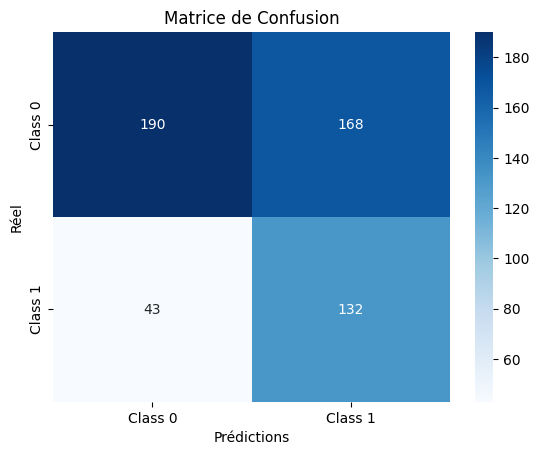

In [32]:
#show_cm(df_merge["Rémunérations"],df_merge.rem)
#show_cm(df_merge["Conditions de travail"],df_merge.ct)
#show_cm(df_merge["Emploi-licenciement"],df_merge.empl)
#show_cm(df_merge["Temps de travail"],df_merge.tt)
#show_cm(df_merge["Autres"],df_merge.autres)
show_cm(df_merge["greve"],df_merge.grève)




In [79]:
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix

# Example of true labels and predicted labels
y_true = np.array(df_merge[["Rémunérations","Conditions de travail","Emploi-licenciement","Temps de travail","Autres"]])
y_pred = np.array(df_merge[["rem","ct","empl","tt","autres"]])

# Compute the confusion matrix
confusion_matrices = multilabel_confusion_matrix(y_true, y_pred)

# Print the confusion matrix for each label
for idx, cm in enumerate(confusion_matrices):
    print(f"Confusion Matrix for label {idx}:")
    print(cm)
    print("\n")


Confusion Matrix for label 0:
[[41 12]
 [ 6 11]]


Confusion Matrix for label 1:
[[26 24]
 [ 3 17]]


Confusion Matrix for label 2:
[[46 17]
 [ 3  4]]


Confusion Matrix for label 3:
[[66  2]
 [ 0  2]]


Confusion Matrix for label 4:
[[34 12]
 [ 6 18]]




### A exceuter pour avoir les resultats des inferences en sortie

In [69]:
prompt="""
Réponds moi dans le format suivant :

Lieu de grève:
Ville de grève : 
Nom de l'entreprise, le cas échéant :
Date de début de grève :
Date de fin de grève :
Durée de grève :
Pays de grève : 
Motif_revendication: [Rémunérations, Conditions de travail, Emploi-licenciement, Temps de travail,Autres revendications] 
Nombre ou proportion de gréviste:
Périmetre de grève (local, sectoriel, interprofessionnelle) :



Texte : 
"""


In [70]:
for index, row in df.iterrows():
    liste=[]
    prompt2 = prompt + row.text
    response = requests.post("http://127.0.0.1:11434/api/generate", json={"model": "llama3.1", "prompt": str(prompt2) })
    response.raise_for_status()
    response_text=''.join([json.loads(line)['response'] for line in response.text.splitlines()])
    print(response_text)
    print("-----------")
    rem,ct,empl,tt,autres,greve=0,0,0,0,0,0
    if "Rémunérations=Oui" in response_text:
        rem=1
    if "Conditions de travail=Oui" in response_text:
        ct=1
    if "Emploi-licenciement=Oui" in response_text:
        empl=1
    if "Temps de travail=Oui" in response_text:
        tt=1
    if "Autres revendications=Oui" in response_text:
        autres=1

    if "Article de grève=Oui" in response_text:
        greve=1




Lieu de grève : Lille-Lesquin
Ville de grève : Lille
Nom de l'entreprise, le cas échéant : Aéroport de Lille-Lesquin et Air France
Date de début de grève : Jeudi 7H00
Date de fin de grève : Vendredi même heure
Durée de grève : 24 heures
Pays de grève : France
Motif_revendication: Emploi-licenciement (Rémunération et embauches supplémentaires)
Nombre ou proportion de gréviste: Non spécifié mais considéré comme "très perturbé"
Périmetre de grève (local, sectoriel, interprofessionnelle) : Local et sectoriel (contrôleurs aériens de l'aéroport de Lille-Lesquin)

Texte : 
Grève du contrôle aérien jeudi à Lille  Plusieurs vols ont été annulés dès mercredi soir en prévision d'un mouvement de grève prévu jeudi à l'aéroport de Lille-Lesquin des contrôleurs aériens, qui réclament des effectifs supplémentaires, a indiqué la direction de l'aéroport dans un communiqué. Vingt-sept vols Air France au départ et à l'arrivée de Lille ont d'ores et déjà été annulés, ainsi qu'un vol Bordeaux-Strasbourg, es